In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dir = '../input/catyuyy'
print(os.listdir(dir))

['cats2']


In [3]:
print(os.listdir(dir+'/cats2')[:20])

['15653.jpg', '208.jpg', '15572.jpg', '473.jpg', '15360.jpg', '15103.jpg', '15463.jpg', '333.jpg', '537.jpg', '369.jpg', '15578.jpg', '275.jpg', '15194.jpg', '212.jpg', '239.jpg', '15317.jpg', '15326.jpg', '15261.jpg', '15689.jpg', '15404.jpg']


In [4]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(dir, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)


In [5]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [6]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

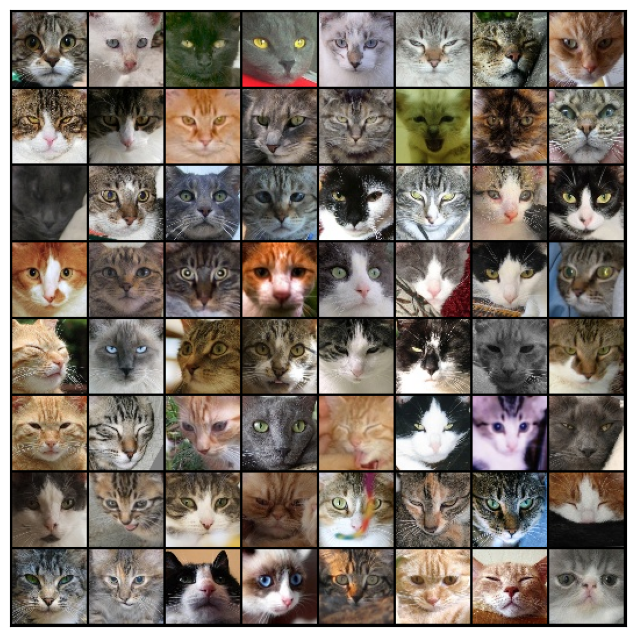

In [7]:
show_batch(train_dl)

In [8]:
def is_cuda_available():
    if torch.cuda.is_available():
        print("CUDA available. Training on GPU!")
        return torch.device('cuda')
    else:
        print("CUDA not available. Training on CPU!")
        return torch.device('cpu')

In [9]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
is_cuda_available()

CUDA not available. Training on CPU!


device(type='cpu')

In [11]:
device=is_cuda_available()
train_dl = DeviceDataLoader(train_dl, device)

CUDA not available. Training on CPU!


In [12]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [13]:
discriminator = to_device(discriminator, device)

In [14]:
latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


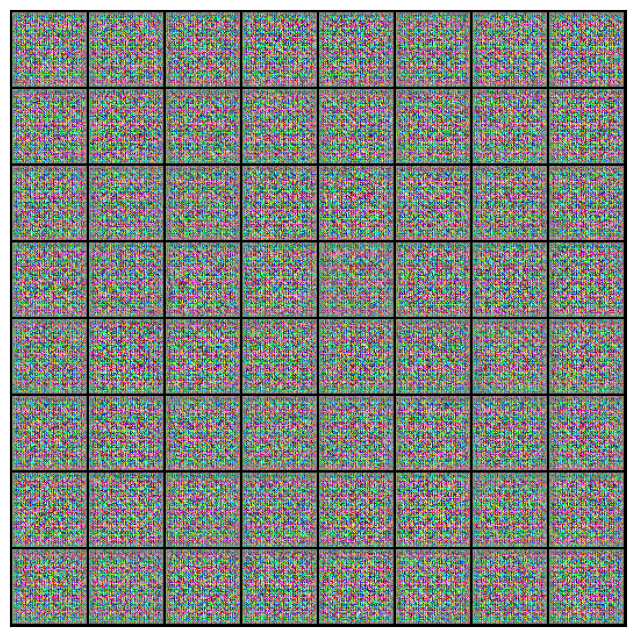

In [15]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [16]:
generator = to_device(generator, device)

In [17]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [18]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [19]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [20]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [21]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


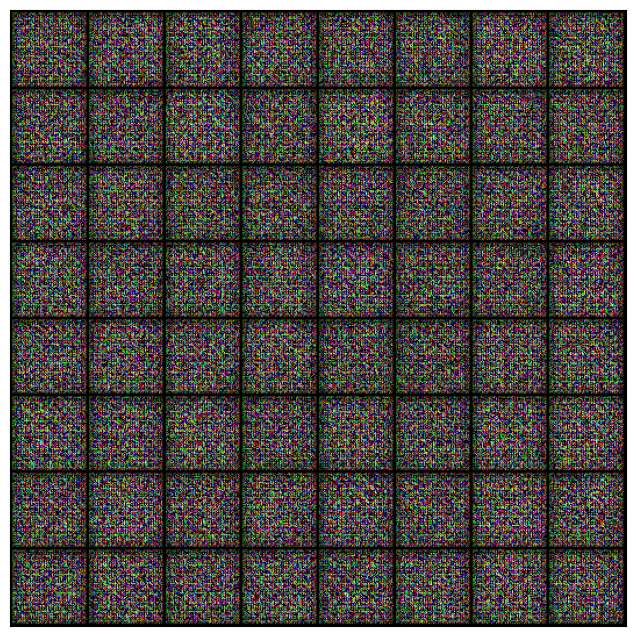

In [22]:
save_samples(0, fixed_latent)

In [23]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores


lr = 0.0003
epochs = 60


history=fit(epochs,lr)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/60], loss_g: 6.9375, loss_d: 0.4628, real_score: 0.7274, fake_score: 0.0223
Saving generated-images-0001.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2/60], loss_g: 11.5237, loss_d: 0.3843, real_score: 0.7900, fake_score: 0.0002
Saving generated-images-0002.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3/60], loss_g: 14.1469, loss_d: 0.5382, real_score: 0.7001, fake_score: 0.0000
Saving generated-images-0003.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4/60], loss_g: 7.4980, loss_d: 0.1344, real_score: 0.8960, fake_score: 0.0006
Saving generated-images-0004.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5/60], loss_g: 15.0730, loss_d: 1.8034, real_score: 0.8956, fake_score: 0.7828
Saving generated-images-0005.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6/60], loss_g: 9.4130, loss_d: 0.1998, real_score: 0.8554, fake_score: 0.0010
Saving generated-images-0006.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7/60], loss_g: 4.2924, loss_d: 0.0757, real_score: 0.9548, fake_score: 0.0252
Saving generated-images-0007.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8/60], loss_g: 8.6723, loss_d: 0.4071, real_score: 0.8563, fake_score: 0.2028
Saving generated-images-0008.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [9/60], loss_g: 8.7096, loss_d: 0.1614, real_score: 0.8736, fake_score: 0.0006
Saving generated-images-0009.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10/60], loss_g: 9.5812, loss_d: 0.8009, real_score: 0.9394, fake_score: 0.4832
Saving generated-images-0010.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [11/60], loss_g: 5.4883, loss_d: 0.6536, real_score: 0.9094, fake_score: 0.3740
Saving generated-images-0011.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [12/60], loss_g: 4.2239, loss_d: 0.4974, real_score: 0.8525, fake_score: 0.2523
Saving generated-images-0012.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [13/60], loss_g: 3.3464, loss_d: 0.4915, real_score: 0.8008, fake_score: 0.2046
Saving generated-images-0013.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [14/60], loss_g: 1.9600, loss_d: 0.6729, real_score: 0.6525, fake_score: 0.1818
Saving generated-images-0014.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [15/60], loss_g: 4.5335, loss_d: 0.4931, real_score: 0.8360, fake_score: 0.2461
Saving generated-images-0015.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [16/60], loss_g: 4.2307, loss_d: 0.3767, real_score: 0.8660, fake_score: 0.1798
Saving generated-images-0016.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [17/60], loss_g: 4.6436, loss_d: 0.4181, real_score: 0.8866, fake_score: 0.2475
Saving generated-images-0017.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [18/60], loss_g: 2.1353, loss_d: 0.6893, real_score: 0.6993, fake_score: 0.2090
Saving generated-images-0018.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [19/60], loss_g: 2.9336, loss_d: 0.5162, real_score: 0.7418, fake_score: 0.1574
Saving generated-images-0019.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [20/60], loss_g: 4.0507, loss_d: 0.4888, real_score: 0.9048, fake_score: 0.3061
Saving generated-images-0020.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [21/60], loss_g: 3.9101, loss_d: 0.5416, real_score: 0.9397, fake_score: 0.3700
Saving generated-images-0021.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [22/60], loss_g: 4.4990, loss_d: 0.6539, real_score: 0.6187, fake_score: 0.0285
Saving generated-images-0022.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [23/60], loss_g: 2.6093, loss_d: 0.3738, real_score: 0.9134, fake_score: 0.2315
Saving generated-images-0023.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [24/60], loss_g: 9.5675, loss_d: 1.5354, real_score: 0.8967, fake_score: 0.7388
Saving generated-images-0024.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [25/60], loss_g: 3.3171, loss_d: 0.4990, real_score: 0.8300, fake_score: 0.2369
Saving generated-images-0025.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [26/60], loss_g: 3.5794, loss_d: 0.4863, real_score: 0.6940, fake_score: 0.0661
Saving generated-images-0026.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [27/60], loss_g: 3.9938, loss_d: 0.4653, real_score: 0.7175, fake_score: 0.0620
Saving generated-images-0027.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [28/60], loss_g: 7.1620, loss_d: 2.4898, real_score: 0.9706, fake_score: 0.8442
Saving generated-images-0028.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [29/60], loss_g: 5.1920, loss_d: 0.9822, real_score: 0.8342, fake_score: 0.5101
Saving generated-images-0029.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [30/60], loss_g: 6.9255, loss_d: 0.7572, real_score: 0.8598, fake_score: 0.4191
Saving generated-images-0030.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [31/60], loss_g: 5.3516, loss_d: 0.4603, real_score: 0.9102, fake_score: 0.2792
Saving generated-images-0031.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [32/60], loss_g: 2.3536, loss_d: 0.4627, real_score: 0.8595, fake_score: 0.2321
Saving generated-images-0032.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [33/60], loss_g: 2.4536, loss_d: 0.4279, real_score: 0.7866, fake_score: 0.1374
Saving generated-images-0033.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [34/60], loss_g: 5.1453, loss_d: 1.0292, real_score: 0.7577, fake_score: 0.4555
Saving generated-images-0034.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [35/60], loss_g: 3.6193, loss_d: 1.5981, real_score: 0.2837, fake_score: 0.0107
Saving generated-images-0035.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [36/60], loss_g: 4.1437, loss_d: 3.0356, real_score: 0.1083, fake_score: 0.0039
Saving generated-images-0036.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [37/60], loss_g: 3.0242, loss_d: 0.5716, real_score: 0.8521, fake_score: 0.3045
Saving generated-images-0037.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [38/60], loss_g: 5.1819, loss_d: 0.6708, real_score: 0.8900, fake_score: 0.3836
Saving generated-images-0038.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [39/60], loss_g: 6.9807, loss_d: 0.7406, real_score: 0.8177, fake_score: 0.3573
Saving generated-images-0039.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [40/60], loss_g: 2.5554, loss_d: 0.6389, real_score: 0.6288, fake_score: 0.0839
Saving generated-images-0040.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [41/60], loss_g: 2.3847, loss_d: 0.6003, real_score: 0.7460, fake_score: 0.1982
Saving generated-images-0041.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [42/60], loss_g: 4.8582, loss_d: 0.2728, real_score: 0.8543, fake_score: 0.0857
Saving generated-images-0042.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [43/60], loss_g: 4.0959, loss_d: 0.5937, real_score: 0.6287, fake_score: 0.0226
Saving generated-images-0043.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [44/60], loss_g: 4.2769, loss_d: 0.5731, real_score: 0.8721, fake_score: 0.3041
Saving generated-images-0044.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [45/60], loss_g: 5.0936, loss_d: 1.5804, real_score: 0.2829, fake_score: 0.0027
Saving generated-images-0045.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [46/60], loss_g: 2.4777, loss_d: 1.4650, real_score: 0.3058, fake_score: 0.0294
Saving generated-images-0046.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [47/60], loss_g: 3.1919, loss_d: 0.6002, real_score: 0.7265, fake_score: 0.1897
Saving generated-images-0047.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [48/60], loss_g: 4.5474, loss_d: 0.5440, real_score: 0.8736, fake_score: 0.2796
Saving generated-images-0048.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [49/60], loss_g: 5.4004, loss_d: 3.8596, real_score: 0.0651, fake_score: 0.0006
Saving generated-images-0049.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [50/60], loss_g: 3.1624, loss_d: 0.6027, real_score: 0.6981, fake_score: 0.1517
Saving generated-images-0050.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [51/60], loss_g: 4.8322, loss_d: 0.5033, real_score: 0.8835, fake_score: 0.2796
Saving generated-images-0051.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [52/60], loss_g: 4.1108, loss_d: 0.4256, real_score: 0.9460, fake_score: 0.2835
Saving generated-images-0052.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [53/60], loss_g: 3.3055, loss_d: 0.3271, real_score: 0.8968, fake_score: 0.1602
Saving generated-images-0053.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [54/60], loss_g: 5.9956, loss_d: 1.0059, real_score: 0.8301, fake_score: 0.4952
Saving generated-images-0054.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [55/60], loss_g: 3.2320, loss_d: 0.5435, real_score: 0.6800, fake_score: 0.0703
Saving generated-images-0055.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [56/60], loss_g: 4.5514, loss_d: 0.4754, real_score: 0.7827, fake_score: 0.1681
Saving generated-images-0056.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [57/60], loss_g: 4.6150, loss_d: 0.9645, real_score: 0.4649, fake_score: 0.0039
Saving generated-images-0057.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [58/60], loss_g: 3.2213, loss_d: 0.9165, real_score: 0.4977, fake_score: 0.0391
Saving generated-images-0058.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [59/60], loss_g: 3.9808, loss_d: 0.3975, real_score: 0.9143, fake_score: 0.2457
Saving generated-images-0059.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [60/60], loss_g: 4.3366, loss_d: 0.3137, real_score: 0.9692, fake_score: 0.2085
Saving generated-images-0060.png


In [24]:
losses_g, losses_d, real_scores, fake_scores = history

In [25]:
from IPython.display import Image

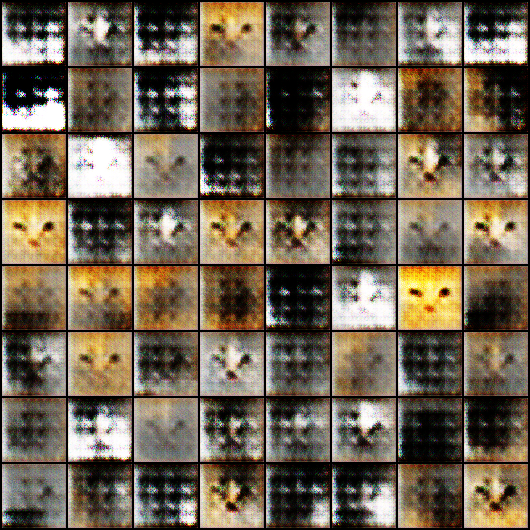

In [26]:
Image('./generated/generated-images-0033.png')

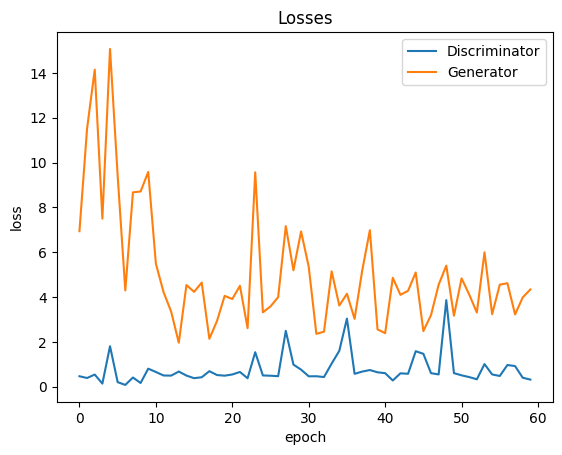

In [27]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

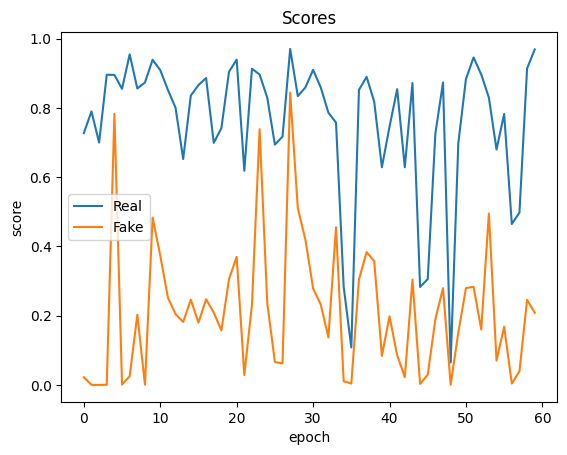

In [28]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Saving generated-images-0000.png


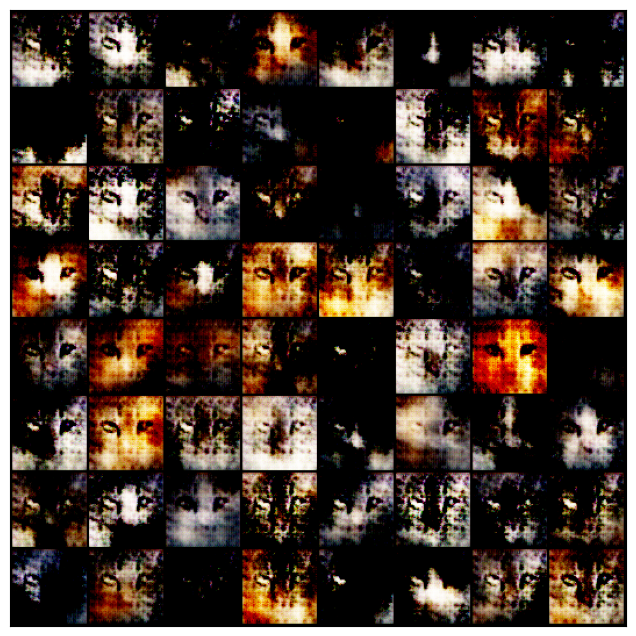

In [29]:
save_samples(0, fixed_latent)